# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.333895
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.064670 analytic: 1.064670, relative error: 2.583930e-08
numerical: -0.580993 analytic: -0.580993, relative error: 5.560235e-08
numerical: -3.187375 analytic: -3.187375, relative error: 1.990665e-09
numerical: -0.008176 analytic: -0.008176, relative error: 8.780573e-06
numerical: 1.802138 analytic: 1.802138, relative error: 6.835783e-09
numerical: 0.753611 analytic: 0.753611, relative error: 2.622541e-08
numerical: -1.929031 analytic: -1.929031, relative error: 3.255787e-09
numerical: 1.241202 analytic: 1.241202, relative error: 1.048209e-08
numerical: 1.369761 analytic: 1.369761, relative error: 3.367924e-09
numerical: -0.275196 analytic: -0.275196, relative error: 2.203464e-08
numerical: -1.476179 analytic: -1.476179, relative error: 1.988122e-08
numerical: 0.370926 analytic: 0.370926, relative error: 1.501223e-07
numerical: 0.670174 analytic: 0.670174, relative error: 3.904930e-08
numerical: -1.859075 analytic: -1.859075, relative error: 3.983412e-10
numerical: -0.575162

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.333895e+00 computed in 0.091039s
vectorized loss: 2.333895e+00 computed in 0.003656s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

for i in learning_rates:
    for j in regularization_strengths:
        softmax=Softmax()
        #loss,dW = softmax_loss_vectorized(W,X_val,y_val,reg=0.00001)
        softmax.train(X_train,y_train,learning_rate =i,reg=j,num_iters=1500,verbose=True)
        y_pred_train = softmax.predict(X_train)
        y_pred_val = softmax.predict(X_val)
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_val = np.mean(y_pred_val == y_val)
        
        results[(i,j)] = (accuracy_train,accuracy_val)
        if(accuracy_val > best_val):
            best_val = accuracy_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 392.461481
iteration 100 / 1500: loss 236.745505
iteration 200 / 1500: loss 143.756149
iteration 300 / 1500: loss 87.682693
iteration 400 / 1500: loss 53.822081
iteration 500 / 1500: loss 33.404372
iteration 600 / 1500: loss 21.028161
iteration 700 / 1500: loss 13.471267
iteration 800 / 1500: loss 9.000350
iteration 900 / 1500: loss 6.293544
iteration 1000 / 1500: loss 4.588750
iteration 1100 / 1500: loss 3.564448
iteration 1200 / 1500: loss 2.969116
iteration 1300 / 1500: loss 2.689156
iteration 1400 / 1500: loss 2.408693


[392.4614810559872,
 390.2036024726237,
 387.86792494287516,
 386.3735469747807,
 383.6441716033628,
 382.21557563326616,
 380.4997527518014,
 377.9705362034075,
 377.0718025126094,
 374.48776587614776,
 372.27609240756885,
 370.77614205156345,
 369.14893330834076,
 366.8131036100832,
 365.24410338081833,
 362.8317406922079,
 361.22514613948636,
 359.9873232756396,
 357.8352333869015,
 355.8536596436234,
 354.08636285106405,
 352.4619002143127,
 350.42480653257934,
 348.6504510516608,
 346.3881197356229,
 345.1397525875827,
 343.50199390940037,
 341.62363253491424,
 339.88572329309324,
 337.9590477794832,
 336.6905147349737,
 334.69461695466987,
 333.3219989762917,
 331.36147000896517,
 330.09238341642094,
 328.08604930405374,
 326.2664659486083,
 325.0310430911936,
 322.7601113726405,
 321.33416182577275,
 319.89604998058525,
 318.1848274123231,
 316.88549514006434,
 314.78241760952733,
 313.259899773263,
 311.8817102371505,
 310.63598931446796,
 308.83889463101343,
 307.4625289858400

iteration 0 / 1500: loss 777.346577
iteration 100 / 1500: loss 285.548268
iteration 200 / 1500: loss 105.767246
iteration 300 / 1500: loss 39.988325
iteration 400 / 1500: loss 15.989628
iteration 500 / 1500: loss 7.160681
iteration 600 / 1500: loss 3.972341
iteration 700 / 1500: loss 2.756126
iteration 800 / 1500: loss 2.286321
iteration 900 / 1500: loss 2.196758
iteration 1000 / 1500: loss 2.078399
iteration 1100 / 1500: loss 2.092088
iteration 1200 / 1500: loss 2.093317
iteration 1300 / 1500: loss 2.093112
iteration 1400 / 1500: loss 2.108488


[777.3465766208001,
 769.6315863426493,
 762.1447723442546,
 754.7999064422866,
 746.6778179694886,
 739.7779617047885,
 732.1276398324552,
 724.9241287248194,
 717.1026047932418,
 709.9802740859755,
 702.9870609200422,
 696.5118048215926,
 689.4718083315937,
 682.3504340392427,
 675.8869962198169,
 668.7383929419874,
 661.823448300806,
 655.8007553339664,
 649.0284296171092,
 642.5297684181874,
 635.695608436878,
 629.5251198771526,
 623.1419924756956,
 617.3144315500305,
 611.101373653103,
 604.9754279729738,
 598.4667093230958,
 592.8878601383444,
 587.1120661189331,
 581.1614418793739,
 575.6448805225647,
 569.3791405345555,
 563.982905130899,
 557.9435681671085,
 552.7710419936243,
 547.1155286286236,
 541.4819933863239,
 535.9439244927448,
 530.948924917593,
 525.753852648078,
 520.4735845135183,
 515.2474328282877,
 510.2529673300308,
 504.811958355196,
 499.87627086296527,
 494.6971851239189,
 490.2851534626053,
 485.39793917464175,
 480.0477521759464,
 475.46324814989595,
 470

iteration 0 / 1500: loss 387.164316
iteration 100 / 1500: loss 32.656725
iteration 200 / 1500: loss 4.461617
iteration 300 / 1500: loss 2.176213
iteration 400 / 1500: loss 2.031626
iteration 500 / 1500: loss 2.056993
iteration 600 / 1500: loss 1.995604
iteration 700 / 1500: loss 2.039927
iteration 800 / 1500: loss 2.020829
iteration 900 / 1500: loss 2.034155
iteration 1000 / 1500: loss 2.047388
iteration 1100 / 1500: loss 1.965313
iteration 1200 / 1500: loss 2.066054
iteration 1300 / 1500: loss 1.998058
iteration 1400 / 1500: loss 2.034434


[387.16431580841,
 377.4712907611803,
 367.83932139516986,
 358.510214664802,
 349.44907544977525,
 340.807847804847,
 332.56896226665344,
 324.1494341976046,
 315.61883432699017,
 307.60868999935224,
 300.45082442086596,
 292.6653992003788,
 285.16536309441926,
 277.9635941084859,
 271.2342696604183,
 264.73212192724066,
 257.8631953777303,
 251.41598968787383,
 245.13262237793887,
 239.27366088880763,
 233.1835507969538,
 227.4179553748325,
 221.87802504793837,
 216.19252436203422,
 210.7933541209917,
 205.689652316093,
 200.66862633528757,
 195.55825782219634,
 191.01319774101165,
 186.12049271430624,
 181.56657544260352,
 177.00437059802402,
 172.65112950230204,
 168.29959374988945,
 164.26522934403457,
 160.31315876569064,
 156.30577943370744,
 152.41605206029732,
 148.72395055597605,
 144.90889342010615,
 141.41043038544478,
 137.7436371163895,
 134.57769842521316,
 131.20599316677803,
 128.0115015641151,
 124.86306296968529,
 121.60809064754527,
 118.78205274868968,
 115.9593109

iteration 0 / 1500: loss 770.152782
iteration 100 / 1500: loss 6.929260
iteration 200 / 1500: loss 2.162598
iteration 300 / 1500: loss 2.077444
iteration 400 / 1500: loss 2.088922
iteration 500 / 1500: loss 2.111665
iteration 600 / 1500: loss 2.008056
iteration 700 / 1500: loss 2.135489
iteration 800 / 1500: loss 2.136113
iteration 900 / 1500: loss 2.141141
iteration 1000 / 1500: loss 2.051737
iteration 1100 / 1500: loss 2.152621
iteration 1200 / 1500: loss 2.078258
iteration 1300 / 1500: loss 2.098177
iteration 1400 / 1500: loss 2.142098


[770.1527824982065,
 732.0007459806363,
 695.5844736453713,
 661.2328909645877,
 628.5280627731701,
 597.7249521983774,
 567.8405500697826,
 540.0232873580742,
 513.0530094246524,
 488.2047268926047,
 463.7961610950452,
 441.07347679922,
 419.496477354985,
 398.8085982574166,
 378.99294443299505,
 360.4357689311088,
 342.63842989172065,
 325.88472353812074,
 309.72530669440994,
 294.30130890113895,
 279.79166326850384,
 265.91629358907323,
 253.17853038279702,
 240.6618229556551,
 228.8397191699209,
 217.71416511805882,
 206.93916205394444,
 196.87963612443585,
 187.14925606427525,
 178.04621810197887,
 169.22868621359663,
 160.94334290424982,
 153.14655929557483,
 145.67654065739552,
 138.58562622650626,
 131.9312438109086,
 125.34352512985133,
 119.17710080133433,
 113.41950842973888,
 107.90123613151219,
 102.82087993813909,
 97.66355038606828,
 92.87998732489008,
 88.49696935000614,
 84.21796782201447,
 80.02970904282456,
 76.14016960426034,
 72.49343550158545,
 69.00751853634857,


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.349306 val accuracy: 0.357000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.334000 val accuracy: 0.345000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.344776 val accuracy: 0.356000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.328959 val accuracy: 0.337000
best validation accuracy achieved during cross-validation: 0.357000


In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.347000


(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'plane')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'car')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'bird')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'cat')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'deer')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'dog')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'frog')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'horse')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'ship')

(-0.5, 31.5, 31.5, -0.5)

Text(0.5,1,'truck')

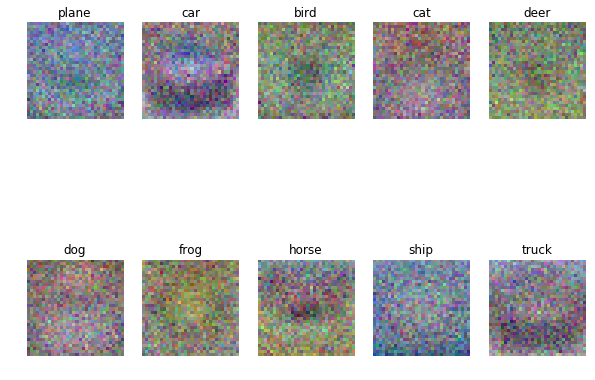

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])